## Our CNN Model
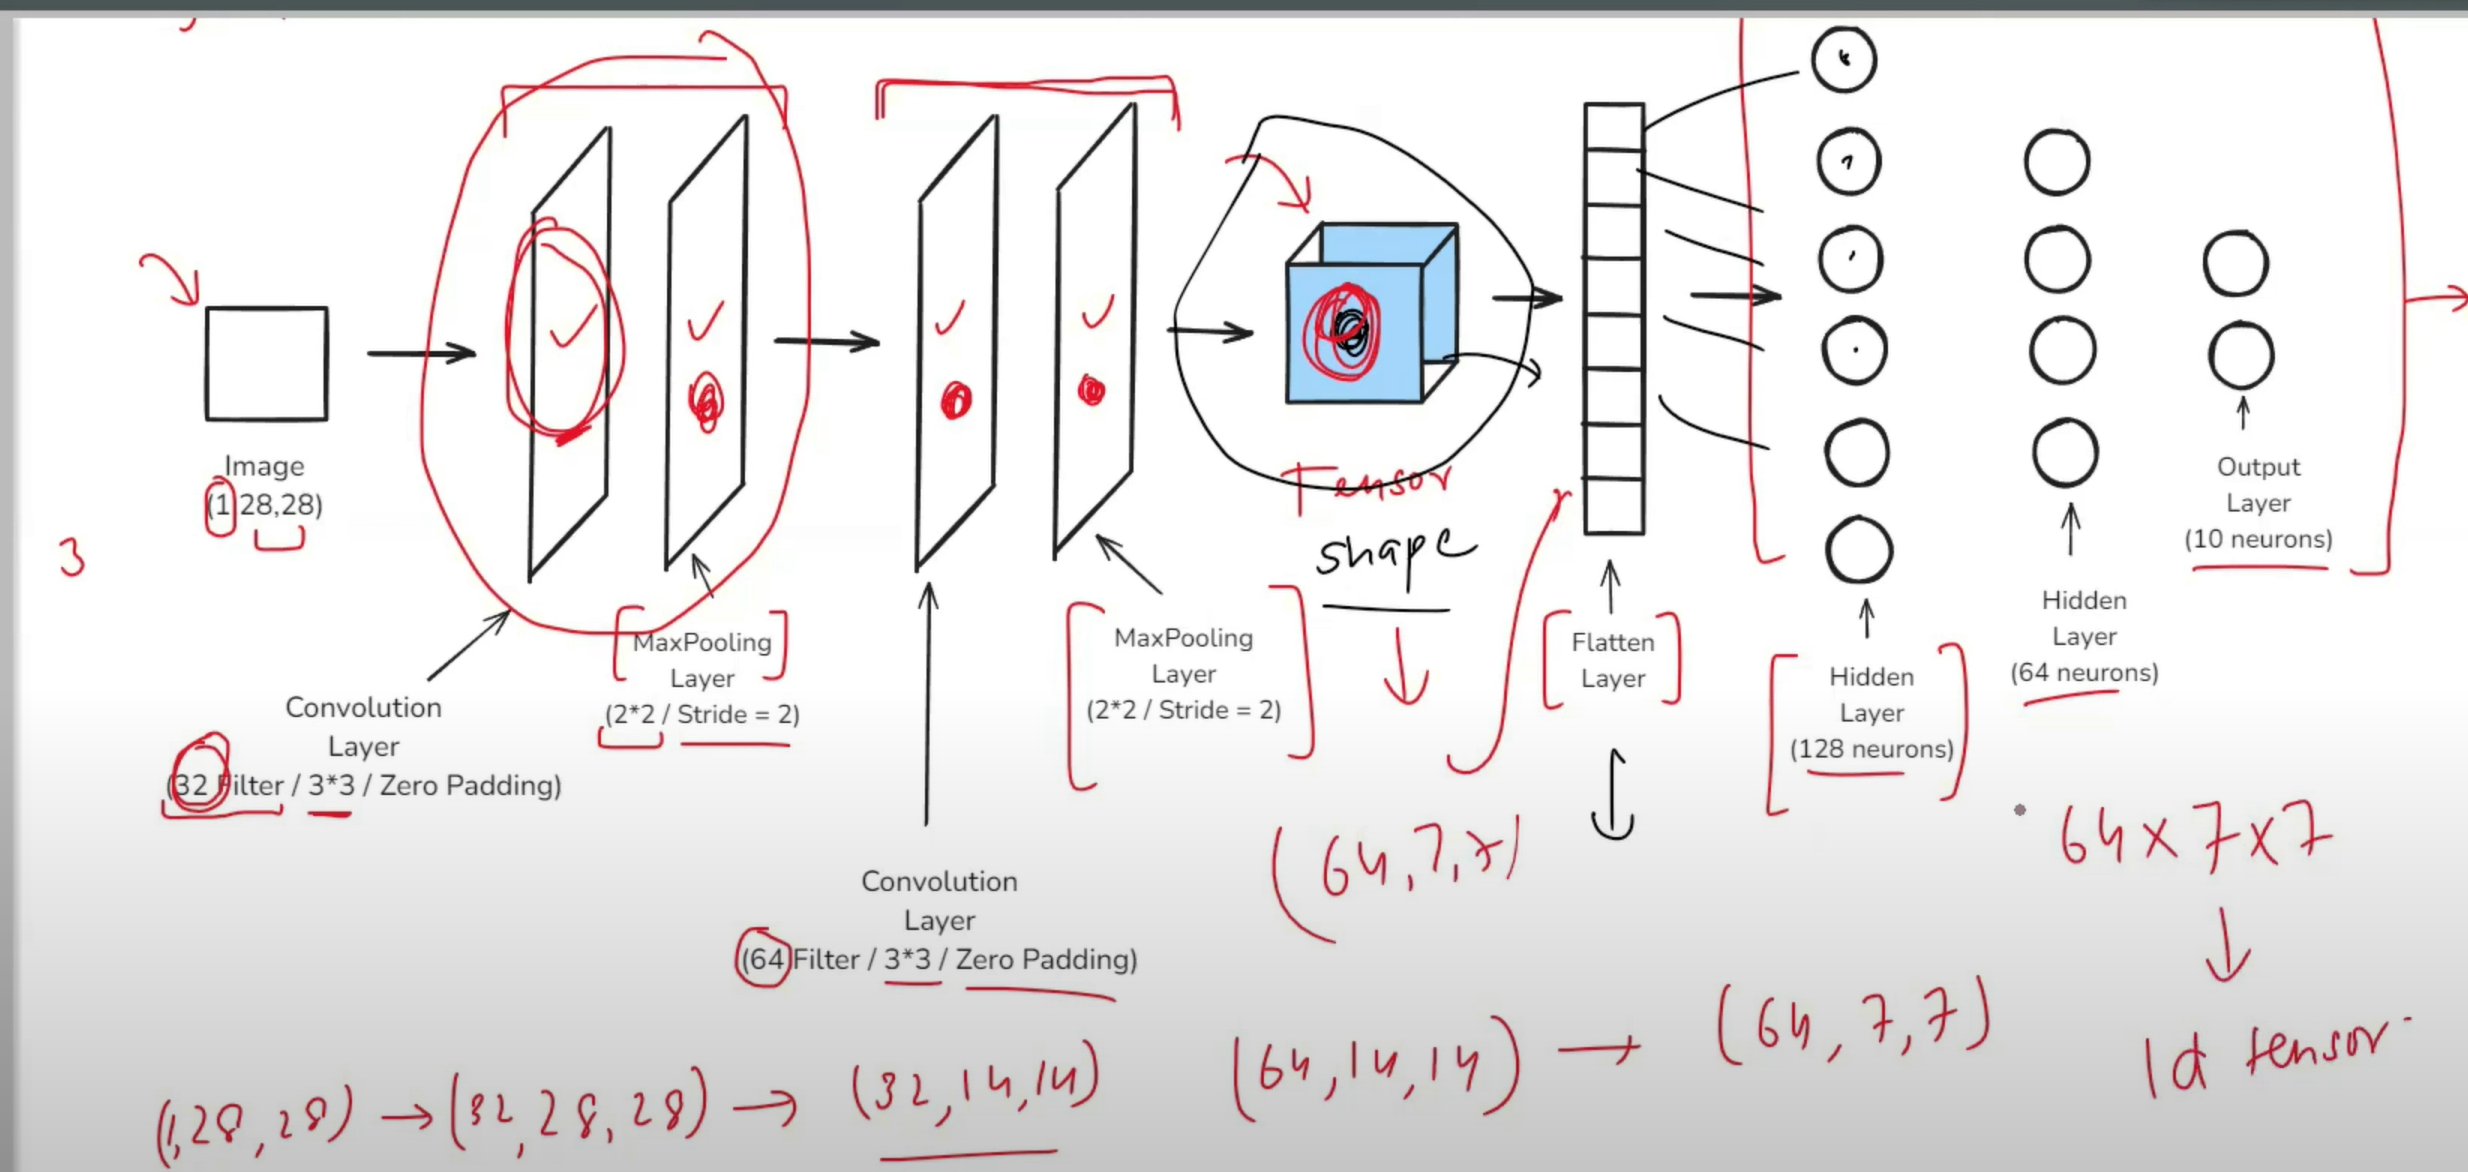

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(60000, 785)

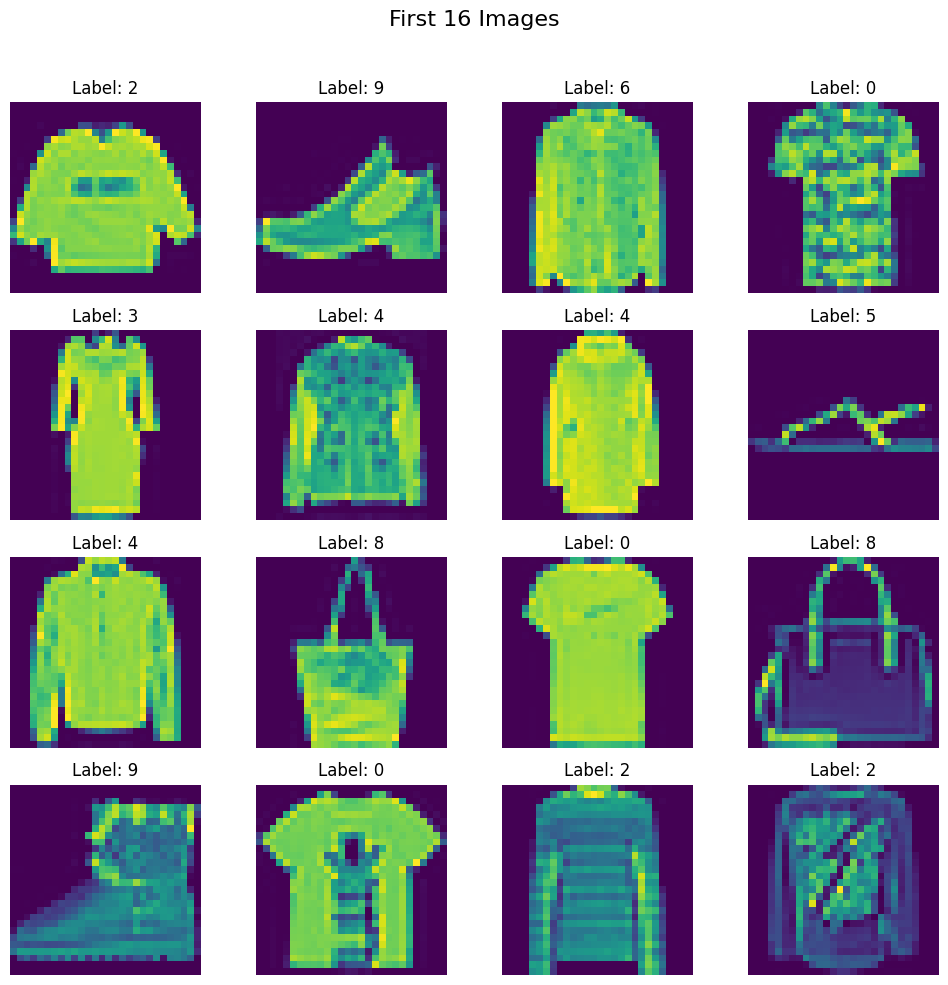

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [7]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1, 28, 28)
     # Here's what each dimension means:
    # - `-1`: This lets PyTorch automatically infer the batch size based on the total number of elements.
    # - `1` : This is the number of channels. For grayscale images like MNIST, it's 1 (not RGB).
    # - `28`: Height of each image.
    # - `28`: Width of each image.
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
     return self.features[idx], self.labels[idx]

In [11]:
train_dataset = CustomDataset(X_train, y_train)

In [12]:
test_dataset = CustomDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [14]:
# Import PyTorch's neural network module
import torch.nn as nn

# Define a custom CNN model by subclassing nn.Module
class MyNN(nn.Module):
    def __init__(self, input_features):
        # Call the constructor of the parent class nn.Module
        super().__init__()

        # Define the feature extraction layers (Convolutional Neural Network part)
        self.features = nn.Sequential(
            # First Convolutional Layer:
            # - input_features: number of input channels (e.g., 1 for grayscale, 3 for RGB)
            # - 32 output feature maps (filters)
            # - kernel size 3x3
            # - padding='same' keeps output size same as input (in PyTorch >=1.10)
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),                          # Apply ReLU activation
            nn.BatchNorm2d(32),                 # Normalize across batch to speed up training and reduce overfitting
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2x (output size becomes half)

            # Second Convolutional Layer:
            # - Input: 32 channels from previous layer
            # - Output: 64 channels
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),                          # Apply ReLU activation
            nn.BatchNorm2d(64),                 # Batch normalization on 64 channels
            nn.MaxPool2d(kernel_size=2, stride=2)   # Downsample again by 2x
        )

        # Define the classification layers (Fully Connected Neural Network part)
        self.classifier = nn.Sequential(
            nn.Flatten(),                       # Flatten the 4D tensor (batch, 64, 7, 7) to 2D (batch, 3136)

            nn.Linear(64 * 7 * 7, 128),         # Fully connected layer: input 3136 features → 128
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(p=0.4),                  # Dropout with 40% probability to prevent overfitting

            nn.Linear(128, 64),                 # Second dense layer: 128 → 64
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(p=0.4),                  # Dropout with 40% probability again

            nn.Linear(64, 10)                   # Final output layer: 64 → 10 (for 10 classes, e.g., MNIST)
        )

    # Forward pass: defines how input data flows through the model
    def forward(self, x):
        x = self.features(x)        # Pass input through convolutional layers
        x = self.classifier(x)      # Pass output through fully connected layers
        return x                    # Return final output (logits)


In [15]:
learning_rate = 0.01
epochs = 100

In [16]:
model = MyNN(1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [17]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # Move both features and labels to the selected device (CPU or GPU)
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Forward pass: compute model predictions
        outputs = model(batch_features)

        # Compute the loss between predicted outputs and actual labels
        loss = criterion(outputs, batch_labels)

        # Backward pass preparation: reset all previous gradients
        optimizer.zero_grad()

        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using computed gradients
        optimizer.step()

        # Accumulate loss to compute average later
        total_epoch_loss += loss.item()


  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.6450910282830398
Epoch: 2 , Loss: 0.38639431828757126
Epoch: 3 , Loss: 0.32646656133234503
Epoch: 4 , Loss: 0.290767049215734
Epoch: 5 , Loss: 0.26493400590121746
Epoch: 6 , Loss: 0.24493953156098724
Epoch: 7 , Loss: 0.23075098300290606
Epoch: 8 , Loss: 0.21270264139274755
Epoch: 9 , Loss: 0.20215426577813925
Epoch: 10 , Loss: 0.1905342649370432
Epoch: 11 , Loss: 0.17520709250184396
Epoch: 12 , Loss: 0.16840841048055638
Epoch: 13 , Loss: 0.15819554210392137
Epoch: 14 , Loss: 0.15021473198849708
Epoch: 15 , Loss: 0.14440294367882112
Epoch: 16 , Loss: 0.13263228715925168
Epoch: 17 , Loss: 0.12614508925378323
Epoch: 18 , Loss: 0.12298828470551719
Epoch: 19 , Loss: 0.11366374603038033
Epoch: 20 , Loss: 0.11041242524810756
Epoch: 21 , Loss: 0.10469578956036518
Epoch: 22 , Loss: 0.09639390426253279
Epoch: 23 , Loss: 0.09319510559986036
Epoch: 24 , Loss: 0.08489869619409243
Epoch: 25 , Loss: 0.08269175408749531
Epoch: 26 , Loss: 0.08441821898682975
Epoch: 27 , Loss: 0.07923

In [18]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [19]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9298333333333333


In [20]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9999791666666666
